## Python多线程

多线程类似于同时执行多个程序，并且多个程序之间可以方便的交流数据。本节课会以最经典的多线程模型之一，生产者-消费者模型为例，介绍`threading`、`queue`库的用法。

### 课程目标

1. 了解`threading`和`queue`基本用法
2. 设计合适的生产者-消费者模型

单线程：

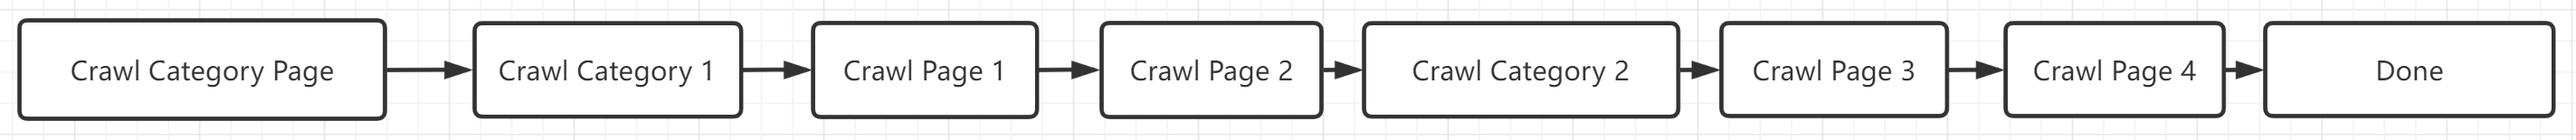

多线程：

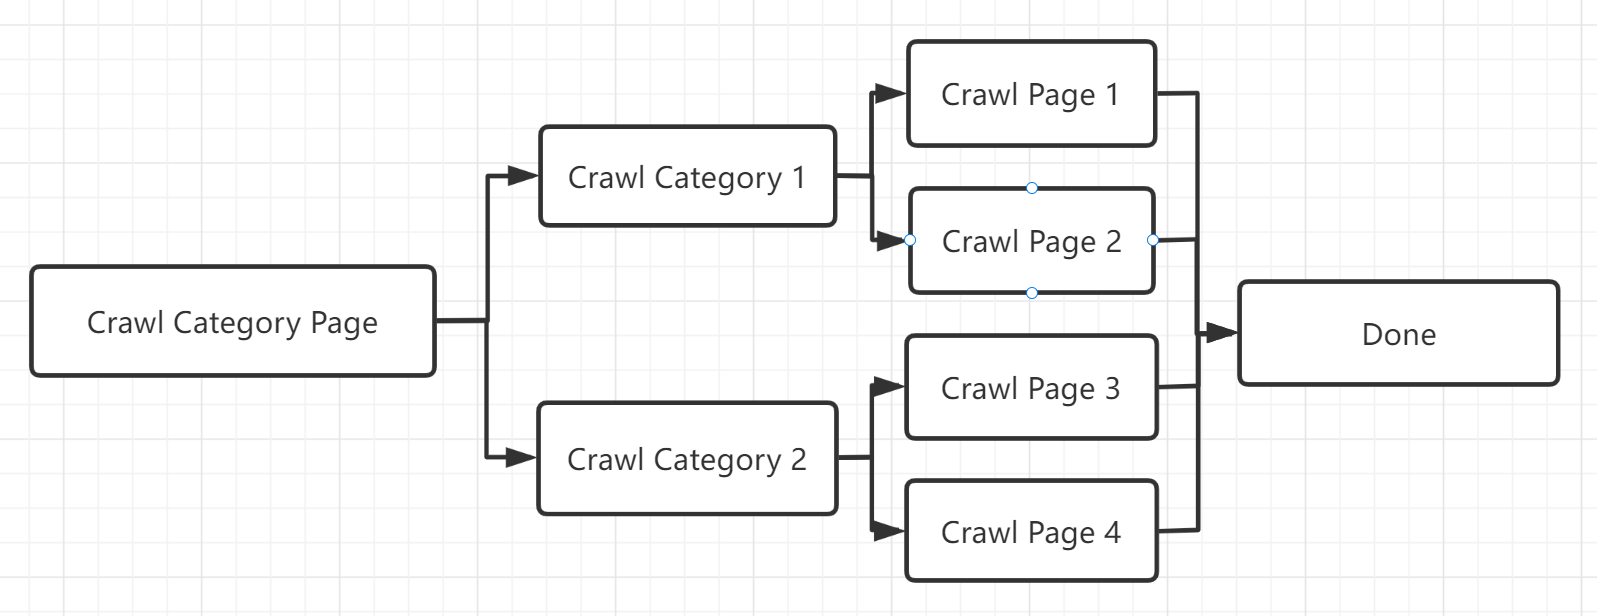

生产者-消费者：
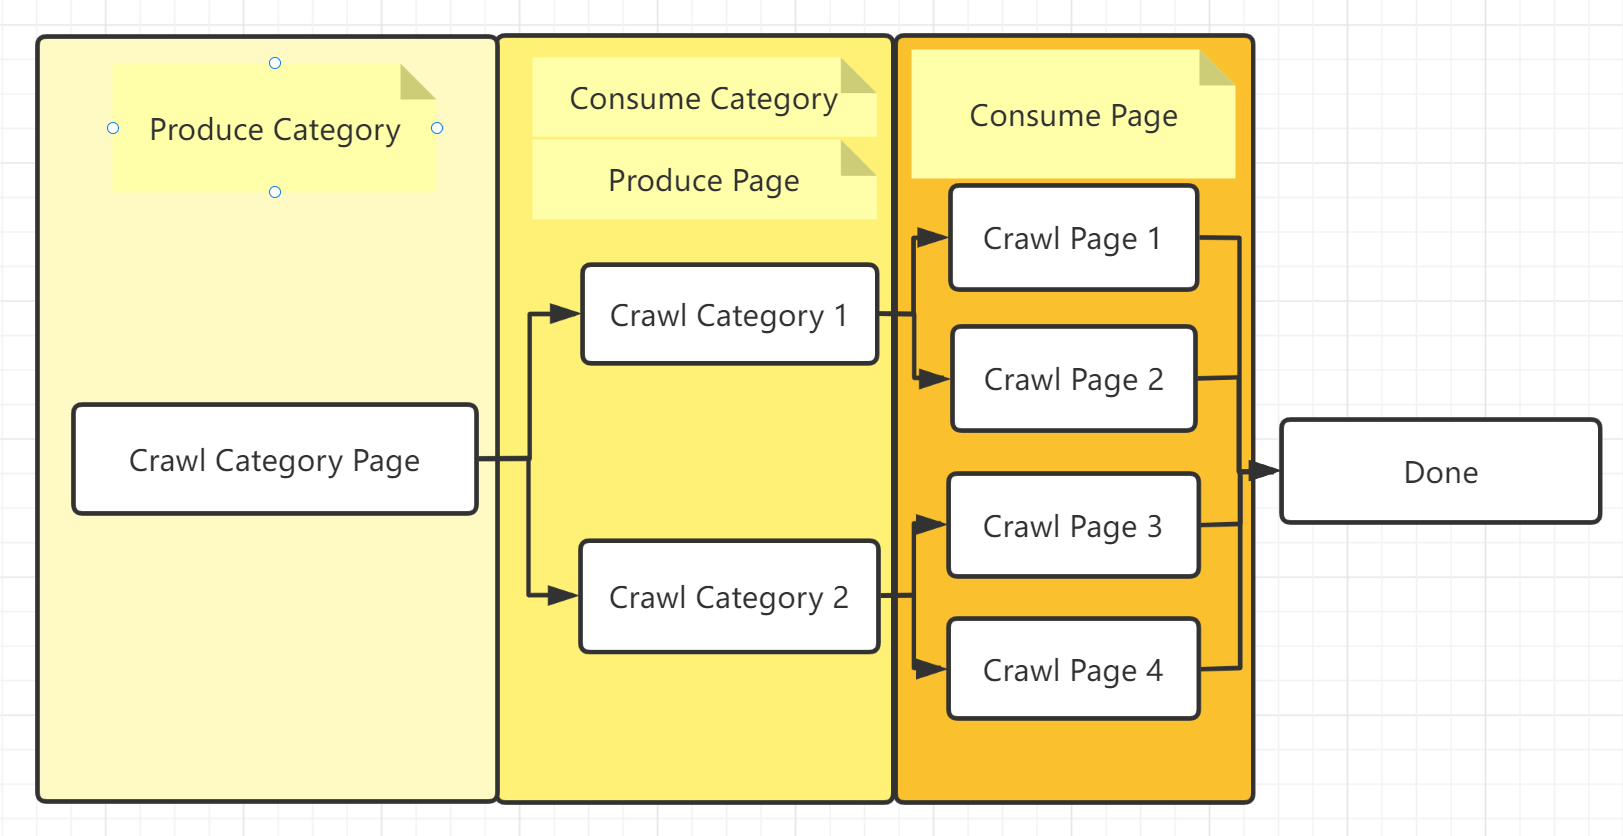

注意，在Jupyter中，如果一个线程没有正常终止，那么会一直运行。此时必须要重启Jupyter（restart kernel）才可以终止。

## threading

In [1]:
import threading
import time

def hello():
    for _ in range(10):
        print('hello')
        time.sleep(1)
        

t = threading.Thread(target=hello) # 创建一个线程Thread对象，target参数传入一个函数
t.start() # 让Thread开始运行

hello
hello
hello
hello
hello


In [2]:
# 在Thread运行的同时，我们还可以同时进行其他操作
print(1+1)

2
hello
hello
hello
hello
hello


In [10]:
t = threading.Thread(target=hello)
t.start()
t.join() # 如果我们在该Thread运行结束后再执行后续代码，则使用.join方法
print(1+1)

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
2


In [11]:
def repeat_msg(msg):
    for _ in range(3):
        print(msg)
        time.sleep(1)
        
t1 = threading.Thread(target=repeat_msg,args=('I amd thread 1',))
t2 = threading.Thread(target=repeat_msg,args=('I amd thread 2',))

t1.start()
time.sleep(.5)
t2.start()

I amd thread 1
I amd thread 2
I amd thread 1
I amd thread 2
I amd thread 1
I amd thread 2


### 练习

使用以上的`hello`和`repeat_msg`函数创建两个线程，实现以下要求：

两个线程同时启动，在`repeat_msg`线程运行完毕后，打印出`Done repeat_msg`；在`hello`线程运行完毕后，打印出`Done hello`。

## queue

`Queue`是队列的意思。我们使用`Queue`来完成线程间的数据传递。



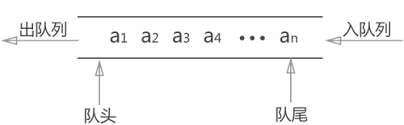

In [3]:
from queue import Queue

q = Queue(10) # 创建一个容量为10的队列，当队列满时，所有的入队操作都会被阻塞

for i in range(5):
    q.put(i) # 使用.put方法将元素入队
    
print('size:',q.qsize()) # 使用.qsize方法查看当前队列中元素数量
    
for _ in range(5):
    print(q.get()) # 使用.get方法获取队头元素
    
print('size:',q.qsize()) # 使用.qsize方法查看当前队列中元素数量

size: 5
0
1
2
3
4
size: 0


结合`threading`库，我们可以在一个线程中向队列中传入数据，在另一个线程中从队列里取出数据。

In [6]:
def producer(q):
    for i in range(5):
        q.put(i) # 生产者向队列中传入数据
        time.sleep(1)
        
def consumer(q):
    for _ in range(5):
        print(q.get()) # 消费者从队列中取出数据
        time.sleep(2)
        
t1 = threading.Thread(target=producer,args=(q,))
t2 = threading.Thread(target=consumer,args=(q,))

start = time.time()
t1.start()
t2.start()
t2.join()
print(time.time()-start)

0
1
2
3
4
10.011605024337769


我们可以创建多个消费者来加速任务进行。

In [8]:
def producer(q):
    for i in range(10):
        q.put(i) # 生产者向队列中传入数据
        time.sleep(1)
        
def consumer(q):
    for _ in range(5):
        print(q.get()) # 消费者从队列中取出数据
        time.sleep(2)
        
t1 = threading.Thread(target=producer,args=(q,))
t2 = threading.Thread(target=consumer,args=(q,))
t3 = threading.Thread(target=consumer,args=(q,))

start = time.time()
t1.start()
t2.start()
t3.start()
t2.join()
t3.join()
print(time.time()-start)

0
1
2
3
4
5
6
7
8
9
11.0130455493927


如果我们不知道一共有多少数据会被生产，如何优雅的终止消费者呢？

答：传入终止信号。

In [20]:
import random

n_consumer = 3

def producer(q,n_consumer):
    rand = int(random.random()*10)
    print('total products:',rand)
    for i in range(rand):
        q.put(i) # 生产者向队列中传入数据
        time.sleep(1)
    for _ in range(n_consumer): # 因为有多个消费者，为确保每个消费者都能收到终止信号，需要传递的终止信号数量应与消费者数量相同
        q.put(None) # 约定None为终止信号，生产者已经生产完了所有数据，消费者在消费完当前数据后就自行终止
        
def consumer(q):
    while True: # 一直运行
        item = q.get()
        if item is None: # 如果收到了None（终止信号），那就终止
            return
        print(item)
        time.sleep(2)
        
for _ in range(n_consumer):
    threading.Thread(target=consumer,args=(q,)).start()
    
threading.Thread(target=producer,args=(q,n_consumer)).start()

total products: 3
0
1
2


### 练习

设想如下场景：

一个电商网站主页下有5个类别页，每个类别页下分别有若干产品页。请设计一个生产者消费者模型，以最快的速度爬完该网站。

规则：

必须要先获取key才能得知value（必须先爬Home才能知道ABCDE，必须先爬A才能知道它有1、2、3页）。

只需对目标`url`执行`crawl`函数即算爬完当前页。`crawl`函数有一定执行时间，用于模拟真实网络传输延迟。

主页url为`Home`，类别页`A`的url为`A`，类别`A`下第1个产品页的url为`A_1`。

最多有5个线程可以同时爬取类别页。最多有5个线程可以同时爬取产品页。

```
import time
def crawl(url):
    print(f'Crawling {url}')
    time.sleep(1)


{'Home':['A','B','C','D','E']}

{
'A':[1,2,3],
'B':[1,2,3,4],
'C':[1],
'D':[1,2,3,4,5],
'E':[1,2]
}
```